In [1]:
# Imports

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
import os
import shutil
import gpt
from PIL import Image
import cv2
import threading

In [2]:
# Open Image

# Read image
IMAGE_PATH = "./recipe.jpg"

image = Image.open(IMAGE_PATH).convert('RGB')

In [3]:
# Process Image for easier reading

# Convert PIL Image to OpenCV format
img = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Reduce noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Inprove Contrast
_, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Median blur to remove remaining spots
denoised = cv2.medianBlur(thresh, 3)

# More smoothing
denoised = cv2.GaussianBlur(denoised, (3, 3), 0)

# Convert back to RGB (but still grayscale)
denoised_3channel = cv2.cvtColor(denoised, cv2.COLOR_GRAY2BGR)
denoised_rgb = cv2.cvtColor(denoised_3channel, cv2.COLOR_BGR2RGB)

# Convert to PIL Image and then to numpy array
processed_pil = Image.fromarray(denoised_rgb)
img_arr = np.array(processed_pil, dtype=np.uint32)
original_img_arr = np.array(processed_pil, dtype=np.uint8)

Text(0.5, 1.0, 'Original Image')

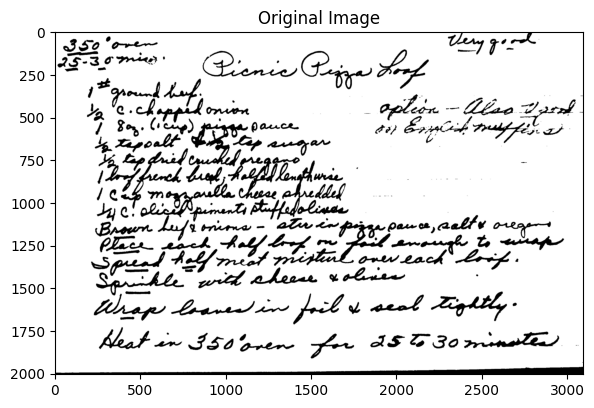

In [4]:
plt.figure(figsize=(15, 7))  # Adjust figure size as needed

#Show Images
plt.subplot(1, 2, 1)  # (rows, columns, index)
plt.imshow(np.array(original_img_arr))
#plt.axis('off')
plt.title("Original Image")

In [5]:
# Set each row to avg color

for row in img_arr:
    R = 0
    G = 0
    B = 0
    for pixel in row:
        R = R + pixel[0]
        G = G + pixel[1]
        B = B + pixel[2]
    
    #Set every pixel to its average r g and b value
    avg_R = R/len(row)
    avg_G = G/len(row)
    avg_B = B/len(row)
    
    avg = (avg_R+avg_B+avg_G)/3
    
    for pixel in row:
        pixel[0] = avg
        pixel[1] = avg
        pixel[2] = avg

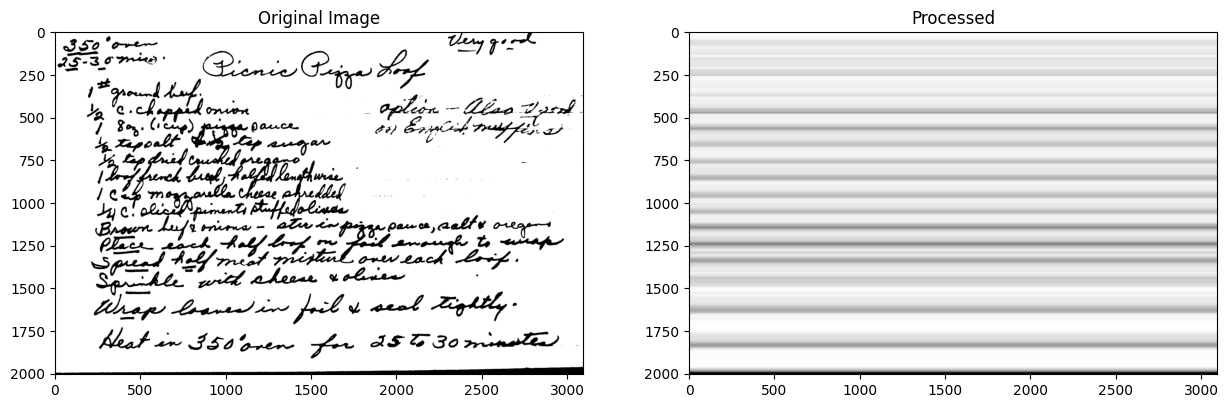

In [6]:
#Show the processed Image

# Convert the processed array back to uint8 for pillow compatibility
formatted_img_arr = np.clip(img_arr, 0, 255).astype(np.uint8)

result_img = Image.fromarray(formatted_img_arr)

plt.figure(figsize=(15, 7))  # Adjust figure size as needed

#Show Images
plt.subplot(1, 2, 1)  # (rows, columns, index)
plt.imshow(np.array(processed_pil))
#plt.axis('off')
plt.title("Original Image")

plt.subplot(1, 2, 2)  # (rows, columns, index)
plt.imshow(np.array(result_img))
#plt.axis('off')
plt.title("Processed")

plt.show()

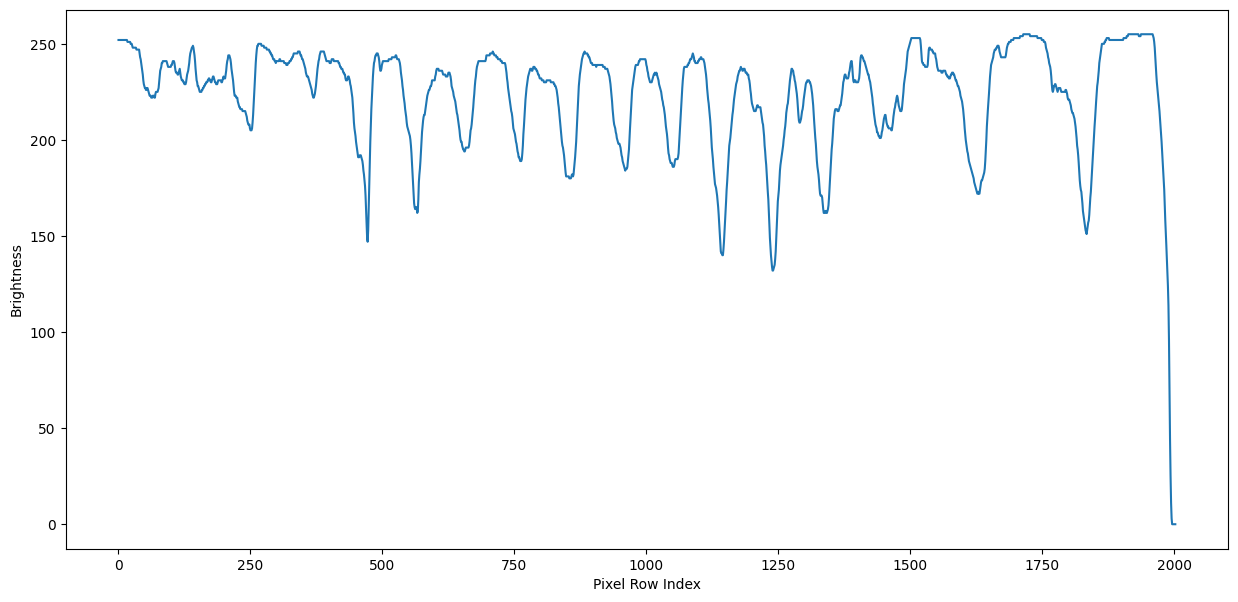

In [7]:
#Display avg brightness 

brightness = []

for row in img_arr:
    brightness.append(row[0][0])

plt.figure(figsize=(15, 7))
plt.plot(brightness)
plt.xlabel("Pixel Row Index")
plt.ylabel("Brightness")
plt.show()

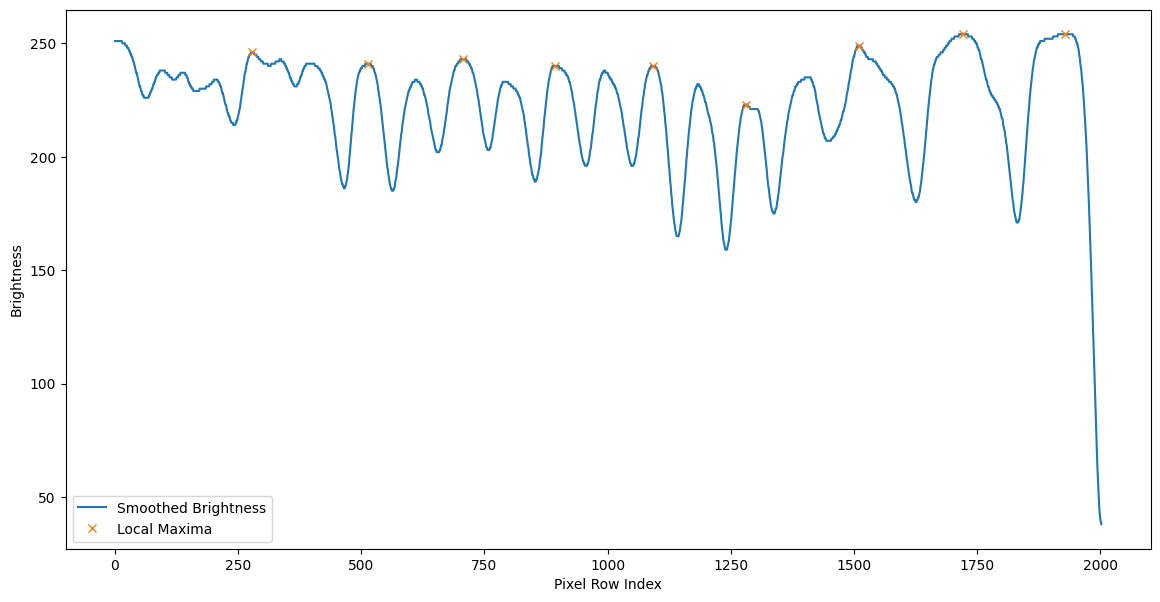

In [8]:
#Find where to split image

# Original data processing
brightness_np = np.array(brightness)
smoothed_data = gaussian_filter1d(brightness_np, sigma=10)

# More selective peak detection
peaks, _ = find_peaks(smoothed_data, 
    distance=100,          # Minimum distance between peaks
    height=None,         # Minimum height for peak to be considered
    prominence=32,       # Minimum prominence (height relative to neighboring valleys)
    width=None,         # Minimum width of peaks
    threshold=None,      # Minimum height difference with neighboring points
)

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(smoothed_data, label="Smoothed Brightness")
plt.plot(peaks, smoothed_data[peaks], "x", label="Local Maxima")
plt.xlabel("Pixel Row Index")
plt.ylabel("Brightness")
plt.legend()
plt.show()

In [9]:
# Add lines to visualize splits

lined_img_arr = original_img_arr.copy()

# Make a line wherever a split will be made

for i, row in enumerate(img_arr):
    if i in peaks:
        for pixel in row:
            pixel[0] = 0
            pixel[1] = 0
            pixel[2] = 255

for i, row in enumerate(lined_img_arr):
    if i in peaks:
        for pixel in row:
            pixel[0] = 0
            pixel[1] = 0
            pixel[2] = 255
            

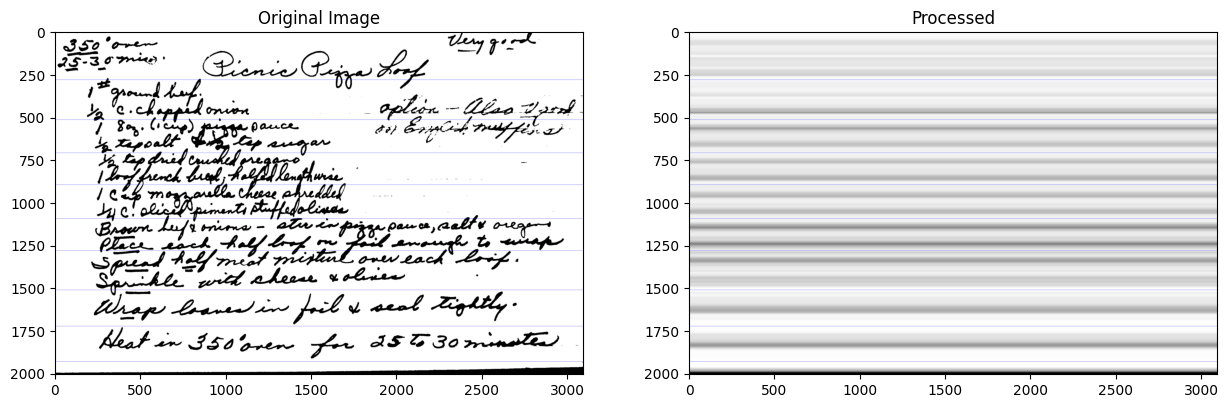

In [10]:
# Display where to split

# Convert the processed array back to uint8 for pillow compatibility
formatted_img_arr = np.clip(img_arr, 0, 255).astype(np.uint8)

result_img = Image.fromarray(formatted_img_arr)
tweaked_img = Image.fromarray(lined_img_arr)

plt.figure(figsize=(15, 7))

#Show Images
plt.subplot(1, 2, 1)  # (rows, columns, index)
plt.imshow(np.array(tweaked_img))
#plt.axis('off')
plt.title("Original Image")

plt.subplot(1, 2, 2)  # (rows, columns, index)
plt.imshow(np.array(result_img))
#plt.axis('off')
plt.title("Processed")

plt.show()

In [11]:
# Split the image into smaller Images

split_images = []
image_build = []

for i, row in enumerate(original_img_arr):
    image_build.append(row)
    
    # If the image should be split on this row
    if i in peaks:
        split_images.append(np.array(image_build))  # Convert image_build to a numpy array before appending
        image_build = []  # Reset the mini image
#Make sure to add the last one
split_images.append(np.array(image_build))

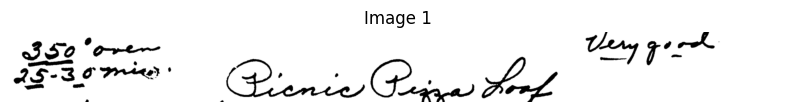

[T1-L1-W1] 3 5 0 ° o v e n 85%
[T1-L1-W2] 2 5 - 3 0  m i n . 80%
[T1-L2-W1] P i c n i c 70%
[T1-L2-W2] P i z z a 75%
[T1-L2-W3] L o a f 80%
[T1-L3-W1] V e r y 90%
[T1-L3-W2] g o o d 88%


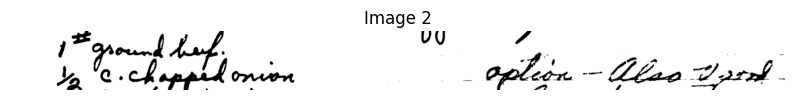

[B-L1-W1] 1 #  90%
[B-L1-W2] g r o u n d  85%
[B-L1-W3] b e e f  80%
[B-L2-W1] 1 / 2  92%
[B-L2-W2] c .  88%
[B-L2-W3] c h o p p e d  83%
[B-L2-W4] o n i o n  80%


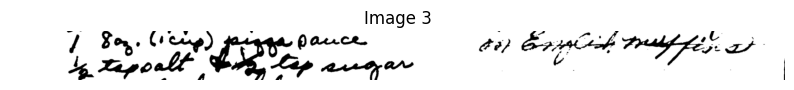

[B-L1-W1] 1  95%
[B-L1-W2] 8 o z .  92%
[B-L1-W3] ( c a n )  90%
[B-L1-W4] p i z z a  88%
[B-L1-W5] s a u c e  85%
[B-L2-W1] 1 / 2  93%
[B-L2-W2] t e a s p  80%
[B-L2-W3] s u g a r  85%
[B-L3-W1] _ _ _ _ _  70%
[B-L4-W1] E n g l i s h  75%
[B-L4-W2] m u f f i n s  78%


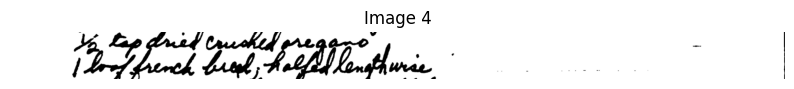

[B-L1-W1] 1 / 2  85%  
[B-L1-W2] t e a s p o o n  80%  
[B-L1-W3] d r i e d  90%  
[B-L1-W4] c r u s h e d  85%  
[B-L1-W5] o r e g a n o  80%  
[B-L2-W1] 1  90%  
[B-L2-W2] l o a f  85%  
[B-L2-W3] f r e n c h  80%  
[B-L2-W4] b r e a d  85%  
[B-L2-W5] ,  95%  
[B-L2-W6] h a l v e d  80%  
[B-L2-W7] l e n g t h w i s e  75%  


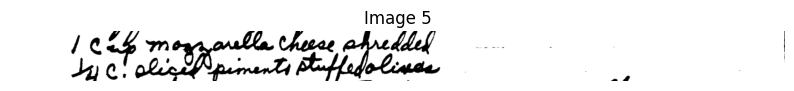

[B-L1-W1] 1  95%  
[B-L1-W2] c u p  90%  
[B-L1-W3] m o z z a r e l l a  88%  
[B-L1-W4] C h e e s e  92%  
[B-L1-W5] s h r e d d e d  85%  
[B-L2-W1] 2 / 3  90%  
[B-L2-W2] C  88%  
[B-L2-W3] o l i v e  85%  
[B-L2-W4] e x p e r i m e n t s  80%  
[B-L2-W5] s t u f f e d  82%  
[B-L2-W6] o l i v e s  90%  


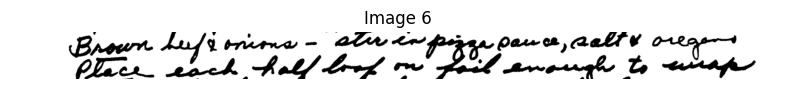

[B-L1-W1] B r o w n  85%  
[B-L1-W2] l e a f  82%  
[B-L1-W3] o n i o n s  87%  
[B-L1-W4] -  90%  
[B-L1-W5] s t i r  80%  
[B-L1-W6] i n  88%  
[B-L1-W7] p i z z a  80%  
[B-L1-W8] s a u c e  78%  
[B-L1-W9] ,  95%  
[B-L1-W10] s a l t  83%  
[B-L1-W11] &  95%  
[B-L1-W12] o r e g a n o  82%  
[B-L1-W13] P l a c e  80%  
[B-L1-W14] e a c h  79%  
[B-L1-W15] h a l f  82%  
[B-L1-W16] l o a f  80%  
[B-L1-W17] f i r m l y  78%  
[B-L1-W18] e n o u g h  76%  
[B-L1-W19] t o  88%  
[B-L1-W20] w r a p  77%


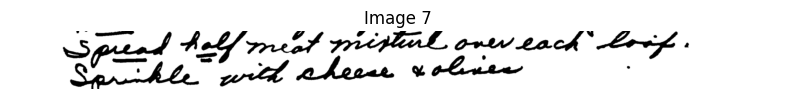

[B-L1-W1] S p r e a d  90%  
[B-L1-W2] h a l f  85%  
[B-L1-W3] m e a t  88%  
[B-L1-W4] m i x t u r e  80%  
[B-L1-W5] o v e r  92%  
[B-L1-W6] e a c h  93%  
[B-L1-W7] l o a f  87%  
[B-L1-W8] .  95%  
[B-L2-W1] S p r i n k l e  86%  
[B-L2-W2] w i t h  91%  
[B-L2-W3] c h e e s e  90%  
[B-L2-W4] &  93%  
[B-L2-W5] o l i v e s  88%  


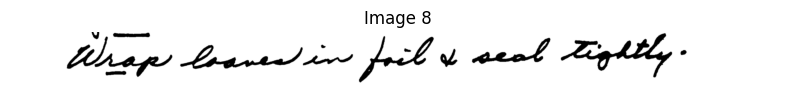

[B-L1-W1] W r a p  90%  
[B-L1-W2] b a n a n a s  88%  
[B-L1-W3] i n  92%  
[B-L1-W4] f o i l  85%  
[B-L1-W5] &  93%  
[B-L1-W6] s e a l  87%  
[B-L1-W7] t i g h t l y  89%  
[B-L1-W8] .  95%  


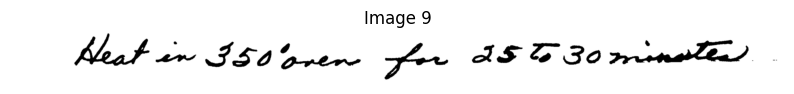

[B-L1-W1] H e a t  95%  
[B-L1-W2] i n  95%  
[B-L1-W3] 3 5 0  88%  
[B-L1-W4] o v e n  95%  
[B-L1-W5] f o r  95%  
[B-L1-W6] 2 5  90%  
[B-L1-W7] t o  90%  
[B-L1-W8] 3 0  90%  
[B-L1-W9] m i n u t e s  95%


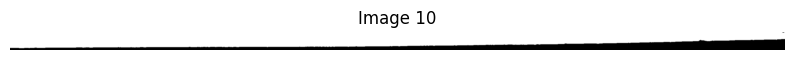

[No Text]


In [12]:
# Save and print all results

# Directory to save the split images
output_dir = "split_images"

# Clear the directory if it exists
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)  # Remove the directory and all its contents
os.makedirs(output_dir, exist_ok=True)  # Recreate the empty directory

responses = []
threads = []
num_threads = 5 

def readImage(responses, i, pic):
    converted_img = Image.fromarray(pic)
    
    # Save the image
    image_path = os.path.join(output_dir, f"image_{i+1}.png")
    converted_img.save(image_path)
    
    #Get chatGPT translation
    responses[i] = gpt.run_chatgpt(image_path)

responses = [None] * len(split_images)  # Initialize responses with size so it is thread safe
threads = []

# Start threads
for i, pic in enumerate(split_images):
    t = threading.Thread(target=readImage, args=(responses, i, pic))
    threads.append(t)
    t.start()

# Wait for all threads to finish
for t in threads:
    t.join()

# Display each image and its response in the original order
for i, pic in enumerate(split_images):
    plt.figure(figsize=(10, 10))
    plt.imshow(pic)
    plt.axis('off')
    plt.title(f"Image {i+1}")
    plt.show()
    print(responses[i])